## Packages

In [1]:
import time
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from scipy.stats import entropy
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Classification Task

## Functions

In [2]:
classes=[[0,0,1],
         [0,0.1,0.9],
         [0,0.01,0.99],
         [0,0.5,0.5],
         [0,0.9,0.1],
         [0,0.99,0.01],
         [0,1,0],
         [0.1,0,0.9],
         [0.01,0,0.99],
         [0.1,0.1,0.8],
         [0.01,0.01,0.98],
         [0.1,0.8,0.1],
         [0.1,0.9,0],
         [0.01,0.98,0.01],
         [0.01,0.99,0],
         [0.5,0,0.5],
         [0.5,0.5,0],
         [0.8,0.1,0.1],
         [0.9,0,0.1],
         [0.9,0.1,0],
         [0.33,0.33,0.33],
         [0.98,0.01,0.01],
         [0.99,0,0.01],
         [0.99,0.01,0],
         [1,0,0]]
  
def to_rgb(triplet):

    red = triplet[0]
    green = triplet[1]
    blue = triplet[2]

    return [green, blue, red]

colors=[]
for triplet in classes:
    #print(i)
    colors.append(to_rgb(triplet))
    
def vectorized_result(j,n):
    e = np.zeros((n, 1))
    e[j] = 1.0
    return e 

## Data loader

In [3]:
def load_data(number_of_inputs=6,scaler=StandardScaler):
    
    df = pd.read_csv("all_copy.csv", sep=";")
    
    if number_of_inputs == 6:
        x=df.iloc[:,17:23]
        y=df.iloc[:,2:5]
    if number_of_inputs == 12:
        x=df.iloc[:,5:17]
        y=df.iloc[:,2:5]
    
    train_inputs =  scaler().fit_transform(x.values)
    training_inputs = [np.reshape(i, (number_of_inputs, 1)) for i in train_inputs] 
    
    results = []
    var=0
    count=0
    concentrations=[]
    for i in y.values:
        results.append(var)
        if count>=98:
            concentrations.append(i)
            count=0
            var+=1
        else:
            count+=1
        
    data = list(zip(training_inputs, results))
    
    t1,t2,t3=[],[],[]
    for i in range(0,len(data),99):
        sample=data[i:i+99]
        
        t1.append([sample.pop(random.randrange(len(sample))) for _ in range(70)])
        t2.append([sample.pop(random.randrange(len(sample))) for _ in range(15)])
        t3.append([sample.pop(random.randrange(len(sample))) for _ in range(14)])
        
    
    t1=np.array(t1).reshape(1750,2)
    t2=np.array(t2).reshape(375,2)
    t3=np.array(t3).reshape(350,2)
    
    np.random.shuffle(t1)
    np.random.shuffle(t2)
    np.random.shuffle(t3)
    
    x_train,y_train=zip(*t1)
    y_train = [vectorized_result(j,25) for j in y_train]
    x_train = [np.reshape(i, (number_of_inputs, 1)) for i in x_train] 
    
    x_test,y_test=zip(*t2)
    y_test = [vectorized_result(j,25) for j in y_test]
    x_test = [np.reshape(i, (number_of_inputs, 1)) for i in x_test] 
    
    x_val,y_val=zip(*t3)
    y_val = [vectorized_result(j,25) for j in y_val]
    x_val = [np.reshape(i, (number_of_inputs, 1)) for i in x_val] 
        
    return x_train,y_train,x_test,y_test,x_val,y_val

## Activation Functions

In [4]:
class Sigmoid(object):

    def fn(z):
        return 1.0/(1.0+np.exp(-z))

    def fn_prime(self, z):
         return 1.0/(1.0+np.exp(-z))*(1-1.0/(1.0+np.exp(-z)))

In [5]:
class ReLu(object):

    def fn(x):
        return x * (x > 0)

    def fn_prime(self,x):
        return 1. * (x > 0)

In [6]:
class Softmax(object):
    
    def fn(z):
        e_z = np.exp(z - np.max(z))
        return e_z / e_z.sum(axis=0)

    def fn_prime(self, z):
        s = z.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

## Cross Entropy Function

In [7]:
class CrossEntropyCost(object):
    
    def fn(predictions, targets):
        
        return log_loss(np.reshape(targets,(targets.shape[0],targets.shape[1])),
                        np.reshape(predictions,(predictions.shape[0],predictions.shape[1])))
    @staticmethod
    def delta(z, a, y):
        return (a-y)

## Neural Network Class

In [8]:
class Network(object):
    
    def __init__(self, activation, sizes,cost=CrossEntropyCost):

        self.layers = len(sizes)
        self.sizes = sizes
        self.variance_scaling()
        self.activation = activation

        self.cost=cost
        
        self.R_w = [np.zeros(np.shape(w)) for w in self.weights]
        self.R_b = [np.zeros(np.shape(b)) for b in self.biases]

        
    def initialize_weights(self):
        
        self.biases=[np.random.randn(j, 1) for i, j in zip(self.sizes[:-1], self.sizes[1:])]
        self.weights=[np.random.randn(j, i)/np.sqrt(i) for i, j in zip(self.sizes[:-1], self.sizes[1:])]
        
    def variance_scaling(self):
        
        self.biases=[0.0*np.random.randn(j, 1) for i, j in zip(self.sizes[:-1], self.sizes[1:])]
        
        self.weights = [np.random.uniform(low=-np.sqrt(3*1.0/np.average([i,j])), 
                                          high=np.sqrt(3*1.0/np.average([i,j])), size=(j,i) ) 
                                            for i, j in zip(self.sizes[:-1], self.sizes[1:])]

    def run(self, train_data, test_data, valid_data, task=0, epochs=100, partition_size=32, eta=0.01, rho=0.9, lmbda=0.01, optimizer="rmsprop", verbose=1):

        t = time.process_time()
        
        train_cost, train_accuracy, test_cost, test_accuracy = [], [], [], []
        
        if task==0:
            accuracy=self.classification_accuracy
        if task==1:
            accuracy=self.threshold_accuracy
        
        for i in range(epochs):
            if verbose==1:
                clear_output(wait=True)
        
            np.random.shuffle(train_data)
            mini_batches=[train_data[k:k+partition_size] for k in range(0,len(train_data),partition_size)]
            
            for mini_batch in mini_batches:
                self.update(mini_batch, eta, rho, lmbda, len(train_data), optimizer)

            train_cost.append(self.total_cost(train_data, lmbda))
            test_cost.append(self.total_cost(test_data, lmbda))  
            train_accuracy.append(accuracy(train_data)/len(train_data))
            test_accuracy.append(accuracy(test_data)/len(test_data))
            
            if verbose==1:
                display("Epoch {}, Accuracy {:,.3f}, Cost {:,.3f}".format(i,test_accuracy[-1],test_cost[-1]))     
         
        elapsed_time = time.process_time() - t
        if verbose==1:
            print("Elapsed time = ",elapsed_time)
        
        if task==0:
            p,r=self.precision_recall(valid_data)
            return elapsed_time, p,r, train_cost,train_accuracy,test_cost,test_accuracy
        if task==1:
            return elapsed_time, accuracy(valid_data)/len(valid_data)
    
    def update(self, mini_batch, eta, rho, lmbda, n, optimizer):
        
        nabla_w,nabla_b = self.gradient(mini_batch)

        if optimizer == "SGD":
            self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
            self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
                    
        if optimizer == "rmsprop":
            
            self.R_w = [np.multiply(rho,r) + (1-rho)*np.multiply(g,g) for r,g in zip(self.R_w,nabla_w)]
            self.weights = [theta - eta*np.multiply(1/np.sqrt(1e-07+r),g) for theta,r,g in zip(self.weights,self.R_w,nabla_w)]

            self.R_b = [np.multiply(rho,r) + (1-rho)*np.multiply(g,g) for r,g in zip(self.R_b,nabla_b)]
            self.biases = [theta - eta*np.multiply(1/np.sqrt(1e-07+r),g) for theta,r,g in zip(self.biases,self.R_b,nabla_b)]
        
    def feedforward(self,a,condition):

        z_s=[];a_s = a;a_s = [a];
        
        for i in range(self.layers-1):
            
            z=np.dot(self.weights[i],a)+self.biases[i]
            z_s.append(z)
    
            a=self.activation[i].fn(z)
            a_s.append(a)

        if condition==1:
            return z_s,a_s
        else:
            return a_s[-1]
        
    def gradient(self, mini_batch):
        
        nabla_b = [np.zeros(np.shape(b)) for b in self.biases]
        nabla_w = [np.zeros(np.shape(w)) for w in self.weights]

        for x,y in mini_batch:
            
            delta_nabla_b = [np.zeros(np.shape(b)) for b in self.biases]
            delta_nabla_w = [np.zeros(np.shape(w)) for w in self.weights]
            
            z_s,a_s=self.feedforward(x,1)

            delta = self.cost.delta(z_s[-1], a_s[-1], y)
            delta_nabla_w[-1] = np.dot(delta , a_s[-2].transpose())
            delta_nabla_b[-1] = delta

            for l in range(self.layers-3, -1,-1):
                sp=self.activation[l].fn_prime(self.activation[l],z_s[l])
                delta = np.dot(self.weights[l+1].transpose(),delta)*sp
                delta_nabla_w[l] = np.dot(delta , a_s[l].transpose())
                delta_nabla_b[l] = delta

            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        return nabla_w,nabla_b 
    
    def total_cost(self, data,lmbda):

        predictions=[]
        labels=[]
        for x, y in data:
            predictions.append(self.feedforward(x,0))
            labels.append(y)
        
        loss=self.cost.fn(np.array(predictions),np.array(labels))
        
        if lmbda!=0:
            loss += 0.5*(lmbda/len(data))*np.sum(np.linalg.norm(w)**2 for w in self.weights)
        
        return loss 
    
    def classification_accuracy(self, data):
        suma=0
        for x,y in data:
            if np.argmax(self.feedforward(x,0)) == np.argmax(y):
                suma+=1
        return suma
    
    def threshold_accuracy(self, data):

        results=[]
        for x,y in data:
            activ=self.feedforward(x,0)
            
            if activ>=0.5:
                results.append((1,y))
            else:
                results.append((0,y))

        tocni=[]
        suma=0
        for x,y in results:
            if int(x==y):
                tocni.append([x,y])
                suma+=1 

        return suma
    
    def precision_recall(self, data):
        
        results = [(np.argmax(self.feedforward(x,0)), np.argmax(y))for (x, y) in data]
        
        y_test, y_pred=zip(*results)
        
        p=precision_score(y_test, y_pred,average=None)
        r=recall_score(y_test, y_pred,average=None)
        
        return p,r

In [9]:
def plotter(title, y1, y1_err,y2, y2_err,color1,color2,limit=0):
    
    f = plt.figure(figsize=(7,6))
    ax = f.add_subplot(111)
    
    plt.plot([i for i in range(len(y1))], y1, color = color1,label="training")
    plt.fill_between([i for i in range(len(y1))], y1 - y1_err, y1 + y1_err,facecolor=color1, alpha=0.45)#, edgecolor="black")
    
    plt.plot([i for i in range(len(y2))], y2,color = color2,label="validation")
    plt.fill_between([i for i in range(len(y2))], y2 - y2_err, y2 + y2_err,facecolor=color2, alpha=0.45)#, edgecolor="black")
    
    if limit ==1:
        major_ticks = np.arange(0, 1.1, 0.1)
        ax.set_yticks(major_ticks)
        ax.set_ylim(0,limit)
    else:
        ax.set_ylim(0,max(y1)+0.5)
        
    ax.set_xlim(0,len(y2))
    
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    plt.grid()
    f.savefig('acc-loss.png', dpi=f.dpi)
    plt.show()
    
def rp_plotter(p_avg,p_std,r_avg,r_std):
    %matplotlib inline

    print("precision and recall")
    print("p=",list(p_avg).count(0.0))
    print("r=",list(r_avg).count(0.0))
    print("p_avg=",np.average(p_avg))
    print("r_avg=",np.average(r_avg))

    c=1
    for i,j in zip(p_avg,r_avg):
        print(c,"\t",np.round(i,2),"\t",np.round(j,2))
        c+=1

    x = [i for i in range(1,len(p_avg)+1)]

    f0 = plt.figure(figsize=(30,8))#,dpi=150)
    ax = f0.add_subplot(111)
    ax.bar([i-0.15 for i in x], p_avg, yerr=p_std,color=colors,align='center', alpha=0.8, ecolor='black', capsize=5, width=0.25,edgecolor="black",label='$precision$')
    ax.bar([i+0.15 for i in x], r_avg, yerr=r_std,color=colors,align='center', alpha=0.8, ecolor='black', capsize=5, width=0.25,edgecolor="black",hatch="//",label='$recall$')
    ax.set_xticks(np.arange(1, 26, step=1))
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.set_ylim(0,1.1)
    ax.set_xlim(0.5,25.5)
    ax.axhline(0.5, color='g', linewidth=1, alpha=0.6)
    ax.axhline(1.0, color='black', linewidth=1)
    
    plt.xticks(fontsize=20)#,rotation=90)
    plt.yticks(rotation=45,fontsize=15, ha="right")
    plt.legend(loc="upper left",fontsize=18)
    f0.savefig('temp0.png', dpi=f0.dpi)
    plt.show()

In [10]:
def plot_data(train_loss_hist,train_acc_hist,test_loss_hist,test_acc_hist,p_list,r_list):

    avg1=list()
    std1=list()
    for item in itertools.zip_longest(*train_loss_hist):
        avg1.append(np.average(item))
        std1.append(np.std(item))

    avg2=list()
    std2=list()
    for item in itertools.zip_longest(*test_loss_hist):
        avg2.append(np.average(item))
        std2.append(np.std(item))

    avg1=np.array(avg1)
    std1=np.array(std1)
    avg2=np.array(avg2)
    std2=np.array(std2)

    acc_avg1=list()
    acc_std1=list()
    for item in itertools.zip_longest(*train_acc_hist):
        acc_avg1.append(np.average(item))
        acc_std1.append(np.std(item))

    acc_avg2=list()
    acc_std2=list()
    for item in itertools.zip_longest(*test_acc_hist):
        acc_avg2.append(np.average(item))
        acc_std2.append(np.std(item))

    acc_avg1=np.array(acc_avg1)
    acc_std1=np.array(acc_std1)
    acc_avg2=np.array(acc_avg2)
    acc_std2=np.array(acc_std2)

    plotter("Loss", avg1,std1,avg2,std2,"blue","green")
    plotter("Accuracy", acc_avg1,acc_std1,acc_avg2,acc_std2,"red","orange",1)
    
    if p_list!=None and r_list!=None:
        p_avg=list()
        p_std=list()
        for item in itertools.zip_longest(*p_list):
            p_avg.append(np.average(item))
            p_std.append(np.std(item))

        r_avg=list()
        r_std=list()
        for item in itertools.zip_longest(*r_list):
            r_avg.append(np.average(item))
            r_std.append(np.std(item))

        rp_plotter(p_avg,p_std,r_avg,r_std)

In [11]:
def build_model(N,inputs=6,epochs=100,hidden_units=100, verbose=1):
    
    train_loss_hist=[]
    test_loss_hist=[]

    train_acc_hist=[]
    test_acc_hist=[]

    p_list=[]
    r_list=[]

    for i in range(N):
        print("N =",i)
        
        x_train,y_train,x_test,y_test,x_val,y_val = load_data(inputs,scaler=StandardScaler)
        net=Network([ReLu,Softmax],[inputs,hidden_units,25],cost=CrossEntropyCost)
        
        train_data=list(zip(x_train,y_train))
        test_data=list(zip(x_test,y_test))
        valid_data=list(zip(x_val,y_val))

        e,p,r,l1,a1,l2,a2 =net.run(train_data, test_data,valid_data, epochs=epochs, 
                                   partition_size=25, eta=0.001, rho=0.9,lmbda=0.0,optimizer="rmsprop",
                                   verbose=verbose)

        train_loss_hist.append(l1)
        train_acc_hist.append(a1)
        test_loss_hist.append(l2)
        test_acc_hist.append(a2)
        p_list.append(p)
        r_list.append(r)
        
    return train_loss_hist,train_acc_hist,test_loss_hist,test_acc_hist,p_list,r_list
    

In [27]:
class_results = build_model(2,inputs=12,hidden_units=25,epochs=100)

'Epoch 99, Accuracy 0.651, Cost 0.918'

Elapsed time =  23.465975999999955


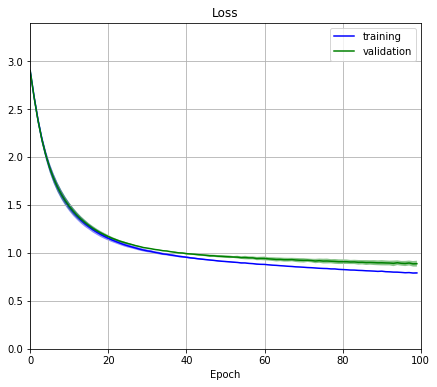

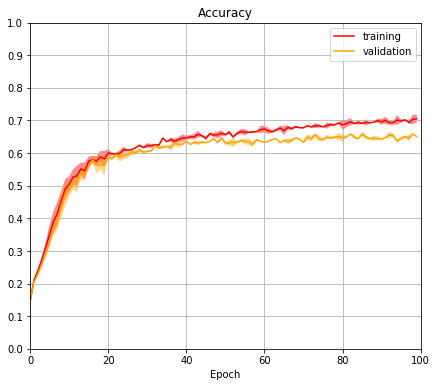

precision and recall
p= 0
r= 0
p_avg= 0.6471428571428571
r_avg= 0.6622985484587651
1 	 0.64 	 0.56
2 	 0.75 	 0.54
3 	 0.25 	 0.45
4 	 0.86 	 0.83
5 	 0.68 	 0.59
6 	 0.86 	 0.89
7 	 0.61 	 0.35
8 	 0.64 	 0.57
9 	 1.0 	 1.0
10 	 0.57 	 0.51
11 	 0.25 	 0.73
12 	 0.82 	 0.89
13 	 0.86 	 0.92
14 	 0.25 	 0.5
15 	 0.21 	 0.16
16 	 1.0 	 1.0
17 	 0.61 	 0.68
18 	 0.32 	 0.49
19 	 0.75 	 0.85
20 	 0.54 	 0.57
21 	 0.82 	 0.86
22 	 0.5 	 0.62
23 	 0.64 	 0.43
24 	 0.96 	 0.97
25 	 0.79 	 0.61


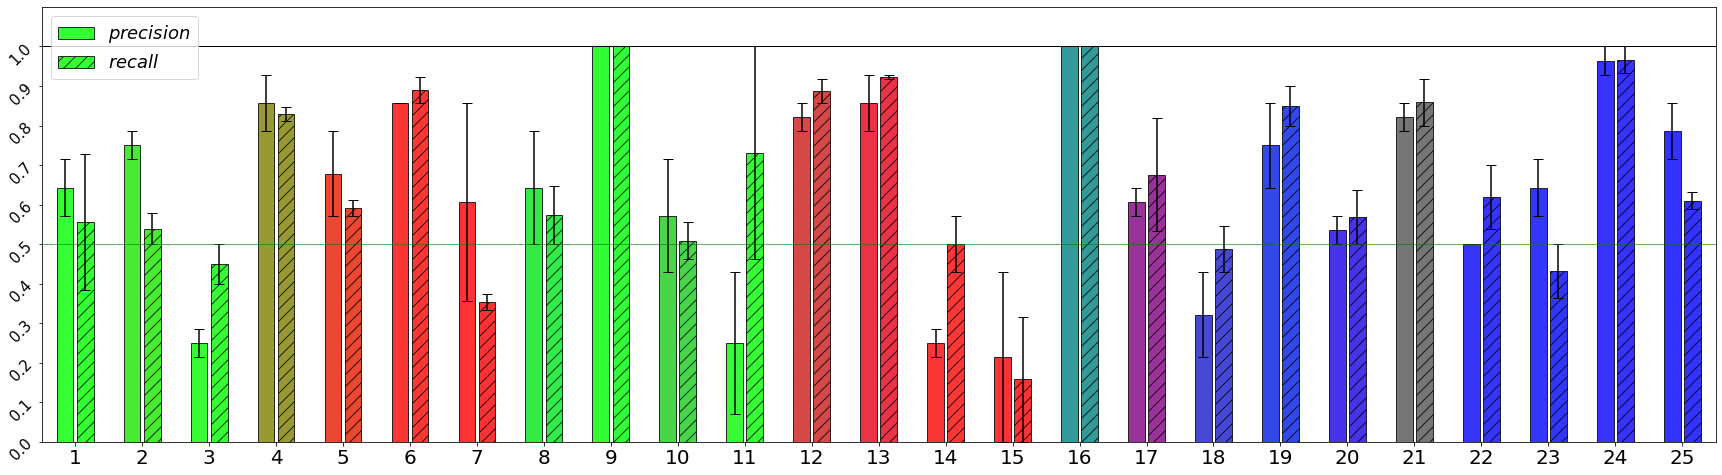

In [28]:
plot_data(class_results[0],class_results[1],class_results[2],class_results[3],class_results[4],class_results[5])

# Results from the paper

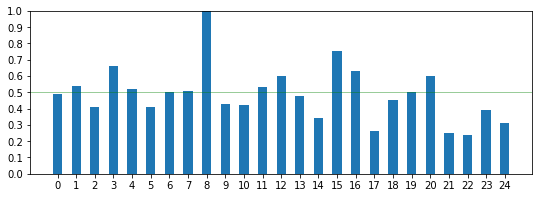

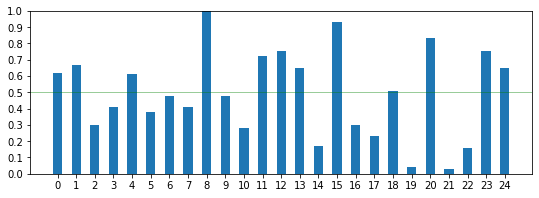

In [14]:
v_precision = [0.49,0.54,0.41,0.66,0.52,0.41,0.50,0.51,1.0,0.43,0.42,0.53,0.6,0.48,0.34,0.75,0.63,0.26,0.45,0.5,0.60,0.25,0.24,0.39,0.31]
v_sensitivity = [0.62,0.67,0.30,0.41,0.61,0.38,0.48,0.41,1.0,0.48,0.28,0.72,0.75,0.65,0.17,0.93,0.3,0.23,0.51,0.04,0.83,0.03,0.16,0.75,0.65]

x = [i for i in range(len(v_precision))]

f0 = plt.figure(figsize=(9,3))
ax = f0.add_subplot(111)
ax.bar(x,v_precision,width=0.5)
ax.set_xticks(np.arange(0, 25, step=1))
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_ylim(0,1.0)
ax.axhline(0.5, color='g', linewidth=1, alpha=0.4)
plt.show()

f1 = plt.figure(figsize=(9,3))
ax = f1.add_subplot(111)
ax.bar(x,v_sensitivity,width=0.5)
ax.set_xticks(np.arange(0, 25, step=1))
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_ylim(0,1.0)
ax.axhline(0.5, color='g', linewidth=1, alpha=0.4)
plt.show()

<br><br><br><br><br><br><br>

# Threshold task

# Preparing the data for the threshold task

In [15]:
def load_threshold_data(number_of_inputs):
    df = pd.read_csv("all_copy.csv", sep=";")
    
    if number_of_inputs == 6:
        x=df.iloc[:,17:23]
        y=df.iloc[:,2:5]
    if number_of_inputs == 12:
        x=df.iloc[:,5:17]
        y=df.iloc[:,2:5]
    
    train_inputs = StandardScaler().fit_transform(x.values)
    
    training_inputs = [np.reshape(i, (number_of_inputs, 1)) for i in train_inputs] 
    training_results = [np.reshape(i, (3, 1)) for i in y.values] 

    data = list(zip(training_inputs, training_results))

    np.random.shuffle(data)
    
    return data

def choose_solution(solution, threshold,inputs=6):
    
    data=load_threshold_data(inputs)
    
    x,y=zip(*data)
    
    #print(y)

    K=[]
    NA=[]
    CA=[]
        
    for i in y:
        a,b,c=i
        if a>=threshold:
            K.append(1)
        if a<threshold:
            K.append(0)
        if b>=threshold:
            NA.append(1)
        if b<threshold:
            NA.append(0)
        if c>=threshold:
            CA.append(1)
        if c<threshold:
            CA.append(0)

    if(solution==0):
        new_data=list(zip(x, K))
    if(solution==1):
        new_data=list(zip(x, NA))
    if(solution==2):
        new_data=list(zip(x, CA))
        
    return new_data

def repackage(data,inputs=6):
    
    t1,t2,t3=[],[],[]
    for i in range(0,len(data),99):
        sample=data[i:i+99]
        
        t1.append([sample.pop(random.randrange(len(sample))) for _ in range(70)])
        t2.append([sample.pop(random.randrange(len(sample))) for _ in range(15)])
        t3.append([sample.pop(random.randrange(len(sample))) for _ in range(14)])
    
    t1=np.array(t1).reshape(1750,2)
    t2=np.array(t2).reshape(375,2)
    t3=np.array(t3).reshape(350,2)
    
    np.random.shuffle(t1)
    np.random.shuffle(t2)
    np.random.shuffle(t3)
    
    x_train,y_train=zip(*t1)
    
    y_train=np.reshape(y_train,(len(y_train),1))
    x_train = [np.reshape(i, (inputs, 1)) for i in x_train] 
    
    x_test,y_test=zip(*t2)
    y_test=np.reshape(y_test,(len(y_test),1))
    x_test = [np.reshape(i, (inputs, 1)) for i in x_test] 
    
    x_val,y_val=zip(*t3)
    y_val=np.reshape(y_val,(len(y_val),1))
    x_val = [np.reshape(i, (inputs, 1)) for i in x_val] 
        
    return x_train,y_train,x_test,y_test,x_val,y_val

In [16]:
data = choose_solution(0, 0.5,inputs=6)

x_train,y_train,x_test,y_test,x_val,y_val = repackage(data,inputs=6)

train_data=list(zip(x_train,y_train))
test_data=list(zip(x_test,y_test))
valid_data=list(zip(x_val,y_val))

# Plot functions

In [25]:
def plot_all_thresholds(arrays,colors,labels):
    
    f = plt.figure(figsize=(12,9))
    ax = f.add_subplot(111)
    for array,color,label in zip(arrays,colors,labels):
        
        thresholds=[0.01,0.1,0.33,0.5,0.8,0.90,0.98,1.0]
    
        stand_errors0=[]
        means0=[]

        for i in array:
            stand_errors0.append(np.std(i))
            means0.append(np.mean(i))

        n=len(thresholds)
        a=np.arange(n)

        error0=np.array(stand_errors0)
        mean0=np.array(means0)

        ax.errorbar(a, means0, yerr=stand_errors0, fmt='o',color=color,markeredgecolor=color,markerfacecolor='white',markeredgewidth=2)
        ax.fill_between(a, mean0-error0, mean0+error0,alpha=0.5,color=color)
        ax.plot(a, means0, color=color,label=label)

    ax.xaxis.set_ticks(a)
    ax.xaxis.set_ticklabels(thresholds)
    ax.set_xlabel('Relative Concentration Threshold (0.1 M)',fontsize=18)
    ax.set_ylabel('Recognition Rate (True)',fontsize=18)
    plt.axhline(y=1.00, color='black', linestyle='dotted')
    plt.axhline(y=0.70, color='black', linestyle='dotted')
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axvline(x=3, color='black', linestyle='dotted')
    plt.legend(loc="lower right",fontsize=18)
    #plt.grid()
    plt.show()

# Threshold Model

In [18]:
def build_threshold_model(N,solution=0,threshold=0.5,inputs=6,epochs=100,hidden_units=50, verbose=0):
    print("Threshold: {:,.3f}".format(threshold),end="")
    th_results=[]
    e_times = []
    for i in range(N):
        #print("N=",i)
        
        if inputs == 6:
            net=Network([ReLu,Sigmoid],[6,hidden_units,1],cost=CrossEntropyCost)
        
        if inputs == 12:
            net=Network([ReLu,Sigmoid],[12,hidden_units,1],cost=CrossEntropyCost)
            
        data = choose_solution(solution, threshold,inputs=inputs)

        x_train,y_train,x_test,y_test,x_val,y_val = repackage(data,inputs=inputs)
        train_data=list(zip(x_train,y_train))
        test_data=list(zip(x_test,y_test))
        valid_data=list(zip(x_val,y_val))
        
        e,th_result =net.run(train_data, test_data,valid_data, epochs=epochs, 
                        task=1, partition_size=25, eta=0.001, rho=0.9,lmbda=0.0,optimizer="rmsprop",
                        verbose=verbose)
        e_times.append(e)
        th_results.append(th_result)
    print(" -> Average accuracy: {:,.3f}, Time: {:,.1f}".format(np.average(th_results),np.sum(e_times)))
        
    return th_results

In [19]:
#old_settings = np.seterr(all='ignore')

thresholds=[0.01,0.1,0.33,0.5,0.8,0.90,0.98,1.0]

KCL=[]
print("Solution=",0)
for threshold in thresholds:
    th_results1=build_threshold_model(2,solution=0,threshold=threshold,inputs=12,epochs=100,hidden_units=100)
    KCL.append(th_results1)

Solution= 0
Threshold: 0.010 -> Average accuracy: 0.776, Time: 30.7
Threshold: 0.100 -> Average accuracy: 0.867, Time: 26.9
Threshold: 0.330 -> Average accuracy: 0.973, Time: 28.4
Threshold: 0.500 -> Average accuracy: 0.977, Time: 28.5
Threshold: 0.800 -> Average accuracy: 0.993, Time: 28.5
Threshold: 0.900 -> Average accuracy: 0.956, Time: 27.0
Threshold: 0.980 -> Average accuracy: 0.924, Time: 27.8
Threshold: 1.000 -> Average accuracy: 0.966, Time: 29.8


In [20]:
thresholds=[0.01,0.1,0.33,0.5,0.8,0.90,0.98,1.0]

NACL=[]
print("Solution=",1)
for threshold in thresholds:
    th_results2=build_threshold_model(2,solution=1,threshold=threshold,inputs=12,epochs=100,hidden_units=100)
    NACL.append(th_results2)

Solution= 1
Threshold: 0.010 -> Average accuracy: 0.804, Time: 28.5
Threshold: 0.100 -> Average accuracy: 0.824, Time: 27.3
Threshold: 0.330 -> Average accuracy: 0.994, Time: 28.6
Threshold: 0.500 -> Average accuracy: 0.979, Time: 30.2
Threshold: 0.800 -> Average accuracy: 0.984, Time: 30.9
Threshold: 0.900 -> Average accuracy: 0.981, Time: 29.0
Threshold: 0.980 -> Average accuracy: 0.993, Time: 28.6
Threshold: 1.000 -> Average accuracy: 0.961, Time: 27.0


In [21]:
thresholds=[0.01,0.1,0.33,0.5,0.8,0.90,0.98,1.0]

CACL=[]
print("Solution=",2)
for threshold in thresholds:
    th_results3=build_threshold_model(2,solution=2,threshold=threshold,inputs=12,epochs=100,hidden_units=100)
    CACL.append(th_results3)

Solution= 2
Threshold: 0.010 -> Average accuracy: 0.867, Time: 30.0
Threshold: 0.100 -> Average accuracy: 0.904, Time: 27.5
Threshold: 0.330 -> Average accuracy: 1.000, Time: 29.7
Threshold: 0.500 -> Average accuracy: 0.991, Time: 31.3
Threshold: 0.800 -> Average accuracy: 1.000, Time: 29.4
Threshold: 0.900 -> Average accuracy: 0.969, Time: 26.6
Threshold: 0.980 -> Average accuracy: 0.970, Time: 27.4
Threshold: 1.000 -> Average accuracy: 0.979, Time: 28.4


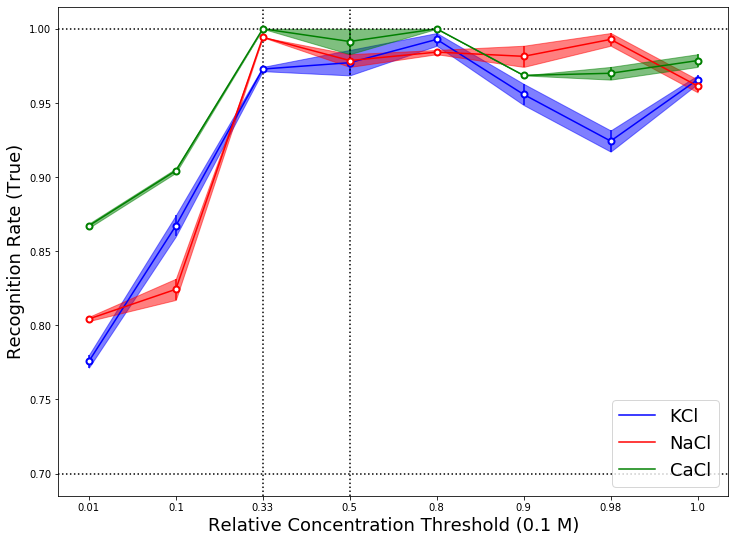

In [26]:
plot_all_thresholds([KCL,NACL,CACL],["blue","red","green"],["KCl","NaCl","CaCl"])

<br><br><br><br><br>